In [1]:
import json
import matplotlib.pyplot as plt
import math
import numpy as np
import os

In [3]:
loaded_data = json.load(open('data.json', 'r'))
len(loaded_data)
loaded_data[0]

{'gain': -72.0,
 'timestamp': 1547980299,
 'channel': 1,
 'station': 'jacky_pc',
 'mac_address': '30:95:e3:16:e6:a5'}

In [20]:
# check our systems
mac_addresses = {
    'jacky_phone': "3c:28:6d:01:c3:57",
    'jesse_phone': "10:f1:f2:83:77:73",
    'rumman_phone': "d4:dc:cd:8b:dc:66",
    'micah_phone': "9a:80:23:73:e8:1c"
}


In [53]:
def get_data(name):
    x = []
    for i in data:
        if i['mac_address'] == mac_addresses[name]:
            x.append(i)
    print(len(x))
    x_sorted = sorted(x, key=lambda k: k['timestamp']) 
    minimum = x_sorted[0]['timestamp']
    for item in x_sorted:
        item['timestamp'] -= minimum
    return x_sorted
jacky = get_data('jacky_phone')
micah = get_data('micah_phone')
rumman = get_data('rumman_phone')
jesse = get_data('jesse_phone')

0


IndexError: list index out of range

In [22]:
def create_circle(x, y, r):
    circle= plt.Circle((x,y), radius=r)
    return circle

def show_shape(patch):
    ax=plt.gca()
    ax.add_patch(patch)

In [4]:
def gaussian_mult(u1, c1, u2, c2):
    u = (c1*u2 + c2*u1)/(c1+c2)
    c = c1*c2/(c1+c2)
    return u,c

'''
this is wrong and we should do proper gaussian matrix math
'''
def gaussian2d_mult(pos1, cov1, pos2, cov2):
    x, cov = gaussian_mult(pos1[0], cov1, pos2[0], cov2)
    y, cov = gaussian_mult(pos1[1], cov1, pos2[1], cov2)
    return (x,y), cov

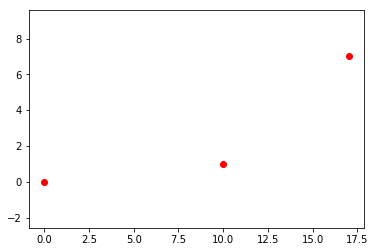

In [13]:
# initialize beacons
b0 = (0,0)
b1 = (10,1)
b2 = (17,7)

plt.axis('equal')
plt.plot(b0[0], b0[1], 'ro')
plt.plot(b1[0], b1[1], 'ro')
plt.plot(b2[0], b2[1], 'ro')


In [18]:
# simulate points as they come
def gen_simulation(data):
    simulation_data = []
    i=0
    while i < len(data):
        points = [data[i]]
        for j in range(i+1, len(data)-1):
            if abs(data[i]['timestamp'] - data[j]['timestamp']) < 10:
                points.append(data[j])
                i += 1
            else:
                break
        i += 1
        simulation_data.append(points)
    return simulation_data
simulation_data = gen_simulation(jesse)


NameError: name 'jesse' is not defined

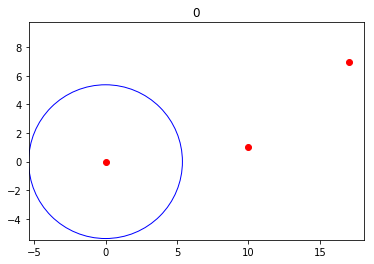

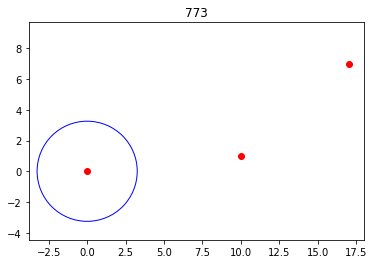

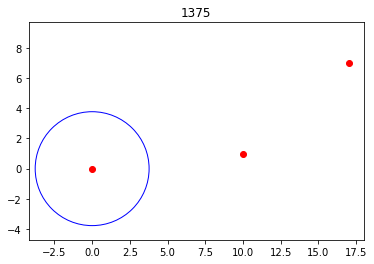

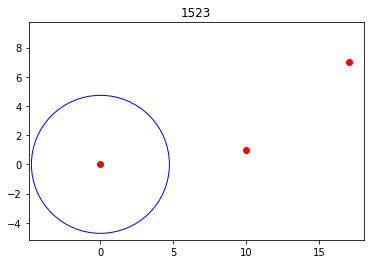

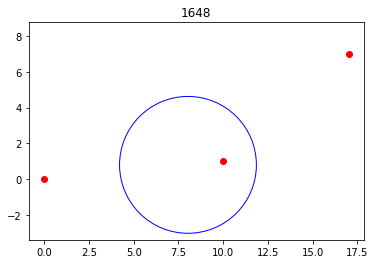

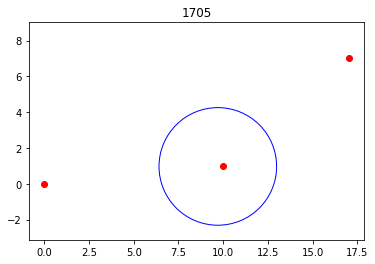

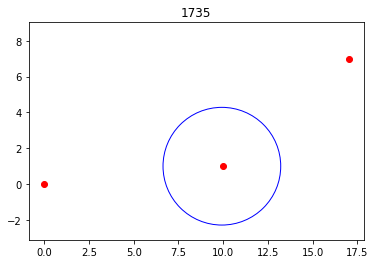

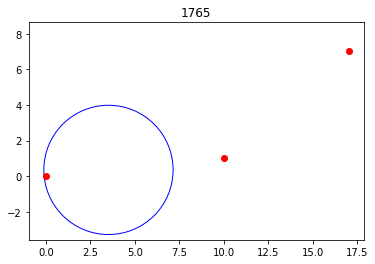

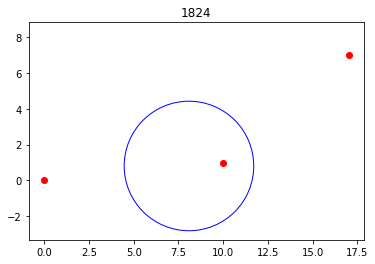

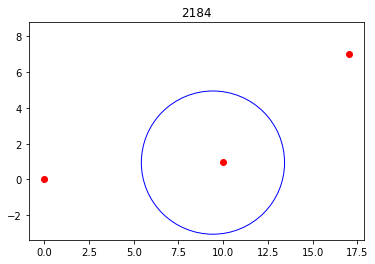

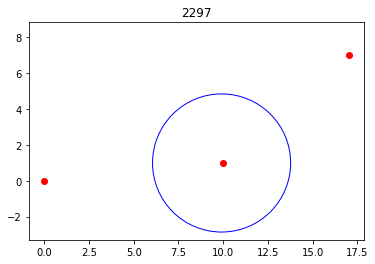

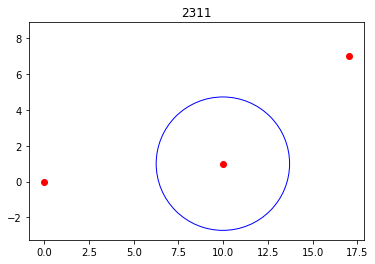

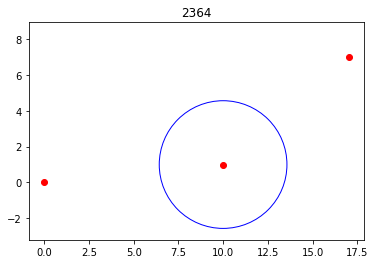

In [27]:
image_dir = './images/'
pos = (0,0)
var = 200000

def run(time_points, prev_pos, prev_cov, plot=True, save=''):
    pos = (0,0)    
    for p in time_points:
        var = (abs(p['gain'])**1.5) * 60
        if p['station'] == 'jacky_pc':
            pos = b0
            var /= 1.2
        if p['station'] == 'rumman_macbook':
            pos = b1
        if p['station'] == 'micah_asus':
            pos = b2
            var /= 1.7
        if plot:
            pass
#             plt.scatter(pos[0], pos[1], s=var, facecolors='none', edgecolors='r')
        final_pos, final_var = gaussian2d_mult(prev_pos, prev_cov, pos, var)

    if plot:
        plt.axis('equal')
        plt.title(time_points[0]['timestamp'])
        plt.plot(b0[0], b0[1], 'ro')
        plt.plot(b1[0], b1[1], 'ro')
        plt.plot(b2[0], b2[1], 'ro')
        plt.scatter(final_pos[0], final_pos[1], s=final_var, facecolors='none', edgecolors='b')
        if save:
            plt.savefig(os.path.join(image_dir, "{:04d}.jpg".format(time_points[0]['timestamp'])))
        plt.show()
    return final_pos, final_var

frames = []
prev_time = 0
for sim_d in simulation_data:
    time_diff = abs(sim_d[0]['timestamp'] - prev_time)
    prev_time = sim_d[0]['timestamp']
    (pos, var) = run(sim_d, pos, var, plot=True, save='./images/')
    if time_diff != 0:
        var *= math.log(time_diff)
    frames.append((sim_d[0]['timestamp'], (pos, var)))

# Density Map

In [109]:
# all unique addresses
unique_addresses = list(set([x['mac_address'] for x in loaded_data]))

In [110]:
# get data for address
def get_data_address(addr, data):
    x = []
    for i in data:
        if i['mac_address'] == addr:
            x.append(i)
    if len(x) == 0:
        return []
    x_sorted = sorted(x, key=lambda k: k['timestamp']) 
    return x_sorted

In [111]:
# simulate points as they come
def gen_simulation(data):
    simulation_data = []
    i=0
    while i < len(data):
        points = [data[i]]
        for j in range(i+1, len(data)-1):
            if abs(data[i]['timestamp'] - data[j]['timestamp']) < 10:
                points.append(data[j])
                i += 1
            else:
                break
        i += 1
        simulation_data.append(points)
    return simulation_data

In [112]:
# run simulation
def run(time_points, prev_pos, prev_cov):
    pos = (0,0)
    for p in time_points:
        var = (abs(p['gain'])**1.5) * 60
        if p['station'] == 'jacky_pc':
            pos = b0
            var /= 1.2
        if p['station'] == 'rumman_macbook':
            pos = b1
        if p['station'] == 'micah_asus':
            pos = b2
            var /= 1.7
        final_pos, final_var = gaussian2d_mult(prev_pos, prev_cov, pos, var)
    return final_pos, final_var

In [113]:
data = get_data_address(unique_addresses[0], loaded_data)
simulation_data = gen_simulation(data)
frames = []
for sim_d in simulation_data:
    (pos, var) = run(sim_d, pos, var,)
    frames.append((sim_d[0]['timestamp'], pos))
frames

interpolated_frames = []
i = 0
while i < len(frames) - 1:
    interpolated_frames.append(frames[i])
    timestamp = frames[i][0]
    while timestamp < frames[i+1][0]-10:
        timestamp += 10
        interpolated_frames.append((timestamp, frames[i][1]))
    i += 1

In [114]:
def interpolate_frames(frames):
    interpolated_frames = []
    i = 0
    while i < len(frames) - 1:
        interpolated_frames.append(frames[i])
        timestamp = frames[i][0]
        while timestamp < frames[i+1][0]-10:
            timestamp += 10
            interpolated_frames.append((timestamp, frames[i][1]))
        i += 1
    return interpolated_frames

In [ ]:
density_data = []
i = 0
for addr in unique_addresses:
    print('Processing {} of {}'.format(i+1, len(unique_addresses)))
    if addr == '':
        pass
    else:
        data = get_data_address(addr, loaded_data)
        simulation_data = gen_simulation(data)
        pos = (0,0)
        var = 200000
        frames = []
        prev_time = simulation_data[0][0]['timestamp']
        for sim_d in simulation_data:
            time_diff = abs(sim_d[0]['timestamp'] - prev_time)
            prev_time = sim_d[0]['timestamp']
            (pos, var) = run(sim_d, pos, var,)
            if time_diff != 0:
                var *= math.log(time_diff)
            frames.append((sim_d[0]['timestamp'], pos))
        density_data.extend(interpolate_frames(frames))
    i+=1

In [116]:
sorted_data = sorted(density_data, key=lambda k: k[0]) 

In [117]:
max_x = max([x[1][0] for x in sorted_data])
min_x = min([x[1][0] for x in sorted_data])

max_y = max([x[1][1] for x in sorted_data])
min_y = min([x[1][1] for x in sorted_data])

In [118]:
# normalize
normalized = []
for item in sorted_data:
    x = [item[0], [item[1][0]/max_x, item[1][1]/max_y]]
    normalized.append(x)

In [119]:
minimum_time = normalized[0][0]
maximum_time = normalized[-1][0]
maximum_time - minimum_time 

2594

In [ ]:
timestamps = [x[0] for x in normalized]
bins = np.arange(minimum_time, maximum_time, 10)
digitized = np.digitize(timestamps, bins) - 1

# init binned data
binned_data = []
for b in bins:
    binned_data.append([int(b), []])

for i in range(len(normalized)):
    point = normalized[i]
    b = digitized[i]
    binned_data[b][1].append(point[1])
print(binned_data)

In [121]:
import json
with open('triangulation.json', 'w') as outfile:
    json.dump(binned_data, outfile)